In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pandas as pd
import numpy as np
import os
import random
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader


c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Tải MobileNetV3 Small hoặc Large
backbone = models.mobilenet_v3_small(pretrained=True) 

def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""

    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Apply convolution and activation without batch normalization."""
        return self.act(self.conv(x))
    
class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher."""

    def __init__(self, c1, c2, k=5):
        """
        Initializes the SPPF layer with given input/output channels and kernel size.

        This module is equivalent to SPP(k=(5, 9, 13)).
        """
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        """Forward pass through Ghost Convolution block."""
        y = [self.cv1(x)]
        y.extend(self.m(y[-1]) for _ in range(3))
        return self.cv2(torch.cat(y, 1))

class SEModule(nn.Module):
    def __init__(self, channels: int, ratio: int = 8) -> None:
        super(SEModule, self).__init__()

        # Average Pooling for Squeeze
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Excitation Operation
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channels // ratio, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Squeeze & Excite Forward Pass
        b, c, _, _ = x.size()

        y = self.avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)

        return x * y


class ASPP(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilations: list[int] = [6, 12, 18, 24]) -> None:
        super(ASPP, self).__init__()

        # Atrous Convolutions
        self.atrous_convs = nn.ModuleList()
        for d in dilations:
            at_conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, dilation=d, padding="same", bias=False
            )
            self.atrous_convs.append(at_conv)

        self.batch_norm = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        
        self.squeeze_excite = SEModule(channels=out_channels)

        self.dropout = nn.Dropout(p=0.5)

        # Upsampling by Bilinear Interpolation
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=16)

        # Global Average Pooling
        self.avgpool = nn.AvgPool2d(kernel_size=(16, 16))

        # 1x1 Convolution
        self.conv1x1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, padding="same", bias=False
        )

        # Final 1x1 Convolution
        self.final_conv = nn.Conv2d(
            in_channels=out_channels * (len(dilations) + 2),
            out_channels=out_channels,
            kernel_size=1,
            padding="same",
            bias=False,
        )

    def forward(self, x):
        # ASPP Forward Pass

        # 1x1 Convolution
        x1 = self.conv1x1(x)
        x1 = self.batch_norm(x1)
        x1 = self.dropout(x1)
        x1 = self.relu(x1)
        x1 = self.squeeze_excite(x1)

        # Atrous Convolutions
        atrous_outputs = []
        for at_conv in self.atrous_convs:
            at_output = at_conv(x)
            at_output = self.batch_norm(at_output)
            at_output = self.relu(at_output)
            at_output = self.squeeze_excite(at_output)
            atrous_outputs.append(at_output)

        # Global Average Pooling and 1x1 Convolution for global context
        avg_pool = self.avgpool(x)
        avg_pool = self.conv1x1(avg_pool)
        avg_pool = self.batch_norm(avg_pool)
        avg_pool = self.relu(avg_pool)
        avg_pool = self.upsample(avg_pool)
        avg_pool = self.squeeze_excite(avg_pool)

        # Concatenating Dilated Convolutions and Global Average Pooling
        combined_output = torch.cat((x1, *atrous_outputs, avg_pool), dim=1)

        # Final 1x1 Convolution for ASPP Output
        aspp_output = self.final_conv(combined_output)
        aspp_output = self.batch_norm(aspp_output)
        aspp_output = self.relu(aspp_output)
        aspp_output = self.squeeze_excite(aspp_output)

        return aspp_output

class Bottleneck(nn.Module):
    """Standard bottleneck."""

    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):
        """Initializes a standard bottleneck module with optional shortcut connection and configurable parameters."""
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        """Applies the YOLO FPN to input data."""
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))
    
class C2f(nn.Module):
    """Faster Implementation of CSP Bottleneck with 2 convolutions."""

    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):
        """Initializes a CSP bottleneck with 2 convolutions and n Bottleneck blocks for faster processing."""
        super().__init__()
        self.c = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0) for _ in range(n))

    def forward(self, x):
        """Forward pass through C2f layer."""
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

    def forward_split(self, x):
        """Forward pass using split() instead of chunk()."""
        y = self.cv1(x).split((self.c, self.c), 1)
        y = [y[0], y[1]]
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))
    
class C3(nn.Module):
    """CSP Bottleneck with 3 convolutions."""

    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        """Initialize the CSP Bottleneck with given channels, number, shortcut, groups, and expansion values."""
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, k=((1, 1), (3, 3)), e=1.0) for _ in range(n)))

    def forward(self, x):
        """Forward pass through the CSP bottleneck with 2 convolutions."""
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))

class C3k(C3):
    """C3k is a CSP bottleneck module with customizable kernel sizes for feature extraction in neural networks."""

    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5, k=3):
        """Initializes the C3k module with specified channels, number of layers, and configurations."""
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)  # hidden channels
        # self.m = nn.Sequential(*(RepBottleneck(c_, c_, shortcut, g, k=(k, k), e=1.0) for _ in range(n)))
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, k=(k, k), e=1.0) for _ in range(n)))

class C3k2(C2f):
    """Faster Implementation of CSP Bottleneck with 2 convolutions."""

    def __init__(self, c1, c2, n=1, c3k=False, e=0.5, g=1, shortcut=True):
        """Initializes the C3k2 module, a faster CSP Bottleneck with 2 convolutions and optional C3k blocks."""
        super().__init__(c1, c2, n, shortcut, g, e)
        self.m = nn.ModuleList(
            C3k(self.c, self.c, 2, shortcut, g) if c3k else Bottleneck(self.c, self.c, shortcut, g) for _ in range(n)
        )

class Upsample(nn.Module):
    def __init__(self, scale_factor=2, mode='nearest'):
        super(Upsample, self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode=mode)
    
    def forward(self, x):
        x = self.upsample(x)
        return x
    
class EggSegNet(nn.Module):
    def __init__(self, num_classes=20):
        super(EggSegNet, self).__init__()
        # Backbone (MobileNetV3 Small)
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        self.backbone_features = self.backbone.features  
        for param in self.backbone_features.parameters():
            param.requires_grad = False
            
        # ASPP Block
        self.aspp = ASPP(in_channels=576, out_channels=768)
        self.aspp_up = Upsample(scale_factor=4, mode='bilinear')  
        self.up_sampled = Upsample(scale_factor=1.6, mode='bilinear')  

        # SPPF Block 
        self.sppf = SPPF(c1=768, c2=768)  
        self.sppf_up = Upsample(scale_factor=4, mode='bilinear')  

        self.conv3 = Conv(768,256, 1, 1)   
        self.c3k2_4 = C3k2(256, 128, n=1, c3k=False, e=0.5, g=1, shortcut=True)
        self.c3k2_4_up = Upsample(scale_factor=5, mode='bilinear')  
        self.conv5 = Conv(128, 64, 1, 1)
        self.c3k2_6 = C3k2(64, 64, n=1, c3k=False, e=0.5, g=1, shortcut=True)
        self.conv7 = Conv(64, 16, 1, 1)
        self.c3k2_8 = C3k2(784, 32, n=1, c3k=True, e=0.5, g=1, shortcut=True)
        self.c3k2_8_up = Upsample(scale_factor=5, mode='bilinear')  
        # Output Layer
        self.output_last = nn.Conv2d(160, num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        features = self.backbone_features(x)

        up_sampled_out_1 = self.up_sampled(features)

        ASPP_output_1 = self.aspp(up_sampled_out_1)
        ASPP_output_2 = ASPP_output_1
    
        SPPF_output= self.sppf(ASPP_output_1)
        SPPF_output_up = self.sppf_up(SPPF_output)
        output = self.conv3(SPPF_output_up)
        output1 = self.c3k2_4(output)
        output = self.conv5(output1)
        output = self.c3k2_6(output)
        output = self.conv7(output)

        output = torch.concat([self.aspp_up(ASPP_output_2), output], dim = 1)
        output3 = self.c3k2_8(output)

        out = torch.cat([self.c3k2_8_up(output1), self.c3k2_4_up(output3)], dim = 1)
        out = self.output_last(out)
        # softmax_output = F.softmax(out, dim=1)
        # _, predicted_mask = torch.max(softmax_output, dim=1, keepdim=True)
        return out


c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
image_path = ["C:/Users/Admin/Desktop/car/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B']]
mask_path = ["C:/Users/Admin/Desktop/car/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B']]

In [4]:
import torch

def dice_loss(pred, target, smooth=1e-6):
    # Dự đoán (sau softmax) và nhãn one-hot
    pred = torch.softmax(pred, dim=1)  # [batch_size, num_classes, H, W]
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])  # [batch_size, H, W, num_classes]
    target = target.permute(0, 3, 1, 2)  # [batch_size, num_classes, H, W]

    # Tính Dice Loss
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = 2.0 * intersection / (union + smooth)
    return 1 - dice.mean()  # Dice Loss = 1 - Dice Score

In [5]:
class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, weight_dice=0.5):
        super(DiceCrossEntropyLoss, self).__init__()
        self.weight_dice = weight_dice
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        # Tính CrossEntropyLoss
        ce = self.ce_loss(logits, target)

        # Tính Dice Loss
        dice = dice_loss(logits, target)

        # Kết hợp hai hàm loss
        return (1 - self.weight_dice) * ce + self.weight_dice * dice


In [6]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SDCDataset(Dataset):
    '''
    Dataset lưu trữ ảnh và mask
    '''
    def __init__(self, img_dirs, mask_dirs, transform_img=None, transform_mask=None):
        self.img_dir = img_dirs
        self.mask_dir = mask_dirs
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.image_names = []
        self.mask_names = []
        if type(self.img_dir) == list:
            for i, j in zip(img_dirs, mask_dirs):
                for n in os.listdir(i):
                    self.image_names.append(os.path.join(i, n))
                    self.mask_names.append(os.path.join(j, n))
        else:
            for n in os.listdir(self.img_dir):
                self.image_names.append(os.path.join(self.img_dir, n))
                self.mask_names.append(os.path.join(self.mask_dir, n))

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
    
        img_name = self.image_names[idx]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        mask_name = self.mask_names[idx]
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)  
    
        if self.transform_img:
            image = self.transform_img(image) 
            mask = self.transform_mask(mask)  

        sample = {'image': image, 'mask': mask}
        return sample

def dataload(image_path, mask_path):

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    data_transforms = {
        'Train': transforms.Compose([
            transforms.ToPILImage(),                     
            transforms.Resize((640, 640)),           
            transforms.ToTensor(),           
            transforms.Normalize(mean, std)          
        ]),
        'Test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),

        'Mask': transforms.Compose([
            transforms.ToPILImage(),                   
            transforms.Resize((640, 640)),          
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.long())
        ])
    }

    # Dataset cho Train và Test
    image_datasets = {
        'Train': SDCDataset(image_path[:-1], mask_path[:-1], transform_img=data_transforms['Train'], transform_mask=data_transforms['Mask']),
        'Test': SDCDataset(image_path[-1], mask_path[-1], transform_img=data_transforms['Test'], transform_mask=data_transforms['Mask'])
    }

    # DataLoader cho Train và Test
    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
        for x in ['Train', 'Test']
    }
    
    return dataloaders, image_datasets


In [7]:
dataloaders, image_datasets = dataload(image_path, mask_path)

In [8]:
model = EggSegNet(21)

In [ ]:
import csv
import copy
import time
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, roc_auc_score

def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #xm.xla_device() 
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for sample in iter(dataloaders[phase]):
                inputs = sample['image'].to(device)
                # inputs.requires_grad = True 
                masks = sample['mask'].to(device)
                masks = masks.squeeze(1)
                # masks.requires_grad = True 
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = torch.argmax(outputs, dim=1).data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
#                     print(y_pred, y_true)
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
#     torch.save(model, os.path.join(bpath, '50epochs_weights.pt'))
    return model

epochs = 100
bpath = "C:/Users/Admin/Desktop/"

# Specify the loss function
criterion = DiceCrossEntropyLoss(weight_dice=0.5)
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Specify the evalutation metrics
metrics = {'f1_score': f1_score} #, 'auroc': roc_auc_score}

trained_model=train_model(model, criterion, dataloaders,optimizer, bpath=bpath, metrics=metrics, num_epochs=epochs)
# xmp.spawn(train_model, args=(model, criterion, dataloaders, optimizer, bpath=bpath, metrics=metrics, num_epochs=num_epochs))

torch.save(trained_model, os.path.join(bpath, f'{epochs}epochs_weights.pt'))

Epoch 1/100
----------
Train Loss: 1.6284
Test Loss: 1.6864
{'epoch': 1, 'Train_loss': 1.6284427642822266, 'Test_loss': 1.6864091157913208, 'Train_f1_score': 0.0, 'Test_f1_score': 0.0}
Epoch 2/100
----------
Train Loss: 1.5097


c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A

Test Loss: 1.6902
{'epoch': 2, 'Train_loss': 1.5096557140350342, 'Test_loss': 1.6902101039886475, 'Train_f1_score': 0.0, 'Test_f1_score': 0.0}
Epoch 3/100
----------
Train Loss: 1.4430


c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\dfine\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A

Test Loss: 1.6061
{'epoch': 3, 'Train_loss': 1.4430115222930908, 'Test_loss': 1.6060585975646973, 'Train_f1_score': 0.0, 'Test_f1_score': 0.0}
Epoch 4/100
----------


In [10]:
bpath = "C:/Users/Admin/Desktop/"
epochs = 6
model_path = os.path.join(bpath, f'{epochs}epochs_weights.pt')

if torch.cuda.is_available():
    model = torch.load(model_path)
else:
    model = torch.load(model_path, map_location=torch.device('cpu'))
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # xm.xla_device()
# print(device)
# Set the model to evaluate mode
model.eval()

originalImage = cv2.imread('C:/Users/Admin/Desktop/car/dataE/dataE/CameraRGB/02_00_008.png')
img = cv2.resize(originalImage, (640, 640), cv2.INTER_AREA).transpose(2,0,1)
img = img.reshape(1, 3, img.shape[1],img.shape[2])

In [11]:
with torch.no_grad():
#     a = model(torch.from_numpy(img).to(device).type(torch.FloatTensor)/255)
    if torch.cuda.is_available():
        a = model(torch.from_numpy(img).to(device).type(torch.cuda.FloatTensor)/255)
    else:
        a = model(torch.from_numpy(img).to(device).type(torch.FloatTensor)/255)

In [21]:
model

EggSegNet(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2

In [22]:
from ultralytics import YOLO
yolo = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:02<00:00, 8.51MB/s]


In [12]:
outImage = a.cpu().detach().numpy()[0]

In [13]:
outImage = np.squeeze(outImage)

In [15]:
np.unique(outImage)

array([ 0,  4,  5,  8,  9, 11, 14, 17, 19], dtype=int64)

In [16]:
mask = cv2.resize(cv2.imread('C:/Users/Admin/Desktop/car/dataE/dataE/CameraSeg/02_00_008.png'), (640, 640))

In [19]:
np.unique(mask[:,:,2])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

(-0.5, 639.5, 639.5, -0.5)

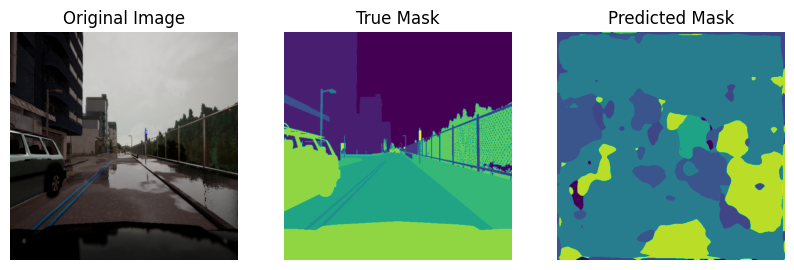

In [20]:
fig, arr=plt.subplots(1,3, figsize=(10,10))

arr[0].imshow(cv2.resize(originalImage, (640, 640)))
arr[0].set_title('Original Image')
arr[0].axis('off')
arr[1].imshow(cv2.resize(cv2.imread('C:/Users/Admin/Desktop/car/dataE/dataE/CameraSeg/02_00_008.png')[:,:,2], (640, 640)))
arr[1].set_title('True Mask')
arr[1].axis('off')
arr[2].imshow(outImage)
arr[2].set_title('Predicted Mask')
arr[2].axis('off')